<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/Alzheimer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!nvidia-smi

Fri Oct 14 06:19:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |    378MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# 連接kaggle api
api_token = {"username":"victor830717","key":"e5ff0036288b15a13b2e2e4444e5051b"}
import json
import zipfile
import os

# 建資料夾 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
# !kaggle datasets download -d {kaggle資料集名稱} --force
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset --force
 
!ls /kaggle

 95% 361M/380M [00:05<00:00, 90.6MB/s]
100% 380M/380M [00:05<00:00, 70.2MB/s]
AugmentedAlzheimerDataset  augmented-alzheimer-mri-dataset.zip	OriginalDataset


In [ ]:
! unzip augmented-alzheimer-mri-dataset.zip 

In [28]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [29]:
data = "/kaggle/AugmentedAlzheimerDataset"
image_dir = Path(data)


# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/kaggle/AugmentedAlzheimerDataset/NonDemented/...,NonDemented
1,/kaggle/AugmentedAlzheimerDataset/NonDemented/...,NonDemented
2,/kaggle/AugmentedAlzheimerDataset/NonDemented/...,NonDemented
3,/kaggle/AugmentedAlzheimerDataset/NonDemented/...,NonDemented
4,/kaggle/AugmentedAlzheimerDataset/NonDemented/...,NonDemented
...,...,...
33979,/kaggle/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33980,/kaggle/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33981,/kaggle/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented
33982,/kaggle/AugmentedAlzheimerDataset/VeryMildDeme...,VeryMildDemented


In [21]:
image_df['Filepath'][0]

'/kaggle/AugmentedAlzheimerDataset/NonDemented/1d20d525-a58f-471e-9649-580ea804299b.jpg'

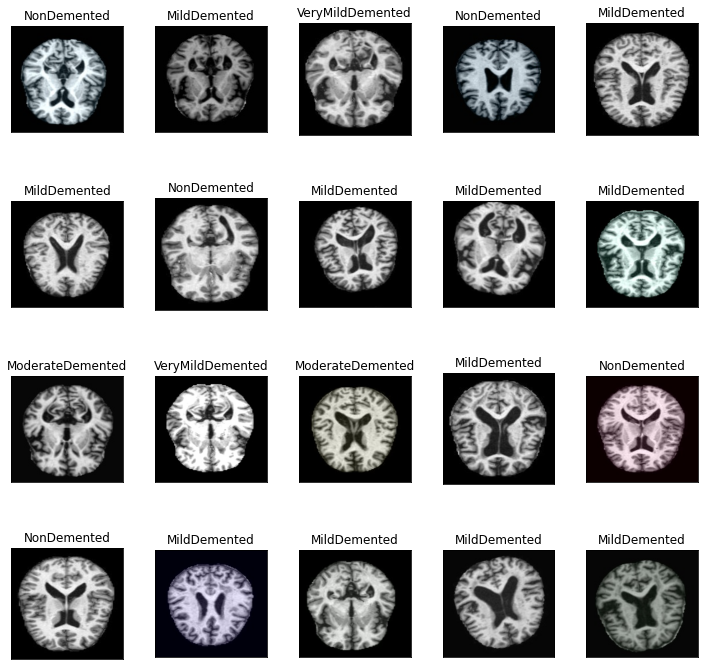

In [30]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [23]:
# from sklearn.model_selection import train_test_split
# import glob
# X_train, X_test, y_train, y_test = train_test_split(image_df['Filepath'], image_df['Label'], test_size=0.2)


In [34]:
# 圖像預處理 ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

# ImageDataGenerator.flow_from_directory
# directory : 目標目錄的路徑。每個類應該包含一個子目錄。
# classes : 可選的類的子目錄列表（例如['dogs', 'cats']）。默認：None。
# 如果未提供，類的列表將自動從 directory 下的子目錄名稱/結構中推斷出來，其中每個子目錄都將被作為不同的類（類名將按字典序映射到標籤的索引）。
# 包含從類名到類索引的映射的字典可以通過 class_indices 屬性獲得。
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [25]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D 
# #flatten 讓他變成同一個維度
# #第一層param: 64 * (1個filter)27 + 64bias = 1792
# #第二層param: 128 * 576 + 128bias =  73856
# layers = [
#     # 一個filter(27) * 64 + 64(bias)
#     Conv2D(32, 3, padding="same", activation="relu", input_shape=(224, 224, 3)),
#     MaxPooling2D(),
#     # 576 * 128 + 128
#     Conv2D(128, 3, padding="same", activation="relu"),
#     MaxPooling2D(),
#     Conv2D(256, 3, padding="same", activation="relu"),
#     MaxPooling2D(),
#     Conv2D(512, 3, padding="same", activation="relu"),
#     GlobalAveragePooling2D(),
#     Dense(4, activation="softmax")
# ]
# model = Sequential(layers)
# model.summary()

In [35]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 32)      

In [36]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 69s 71ms/step - loss: 0.7758 - accuracy: 0.6516 - val_loss: 0.4716 - val_accuracy: 0.8002
Epoch 2/10
850/850 [==============================] - 60s 71ms/step - loss: 0.3962 - accuracy: 0.8355 - val_loss: 0.3188 - val_accuracy: 0.8686
Epoch 3/10
850/850 [==============================] - 60s 70ms/step - loss: 0.2347 - accuracy: 0.9048 - val_loss: 0.2474 - val_accuracy: 0.8971
Epoch 4/10
850/850 [==============================] - 60s 71ms/step - loss: 0.1495 - accuracy: 0.9431 - val_loss: 0.2181 - val_accuracy: 0.9130
Epoch 5/10
850/850 [==============================] - 62s 72ms/step - loss: 0.1102 - accuracy: 0.9577 - val_loss: 0.2149 - val_accuracy: 0.9242
Epoch 6/10
850/850 [==============================] - 60s 70ms/step - loss: 0.0797 - accuracy: 0.9697 - val_loss: 0.2407 - val_accuracy: 0.9191
Epoch 7/10
850/850 [==============================] - 60s 70ms/step - loss: 0.0659 - accuracy: 0.9767 - val_loss: 0.2433 - val_accuracy:

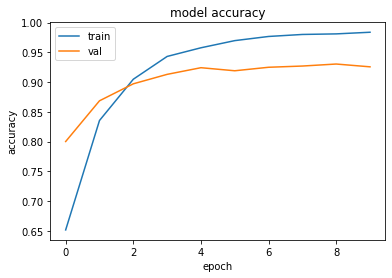

In [37]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

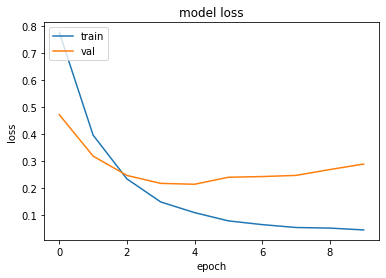

In [38]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
# predict

img = keras.preprocessing.image.load_img(
    image_df["Filepath"][1000], target_size=(224, 224)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predictions
score = predictions[0]
map = dict(enumerate(train_images.class_indices))
print('map:',map)

def mapping(score):
  map = dict(enumerate(train_images.class_indices))
  for i in range(4):
    if score[i] == 1.0:
      return map[i]

print('predict:',mapping(score))



print('actual:',image_df["Label"][1000])


1/1 [==============================] - 0s 18ms/step
map: {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
predict: NonDemented
actual: NonDemented
